# ETF Pipeline

> ETF flow decompositions pipeline.

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# | default_exp etf_pipeline

In [ ]:
# | hide
from nbdev.showdoc import *

In [ ]:
# | hide
import sys
sys.path.append("../")

In [ ]:
# | export
import os

import click
from arcticdb import Arctic, LibraryOptions
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
from pathlib import Path
from lobster_tools.config import MainConfig, register_configs
from lobster_tools.preprocessing import *
from lobster_tools.querying import *
from lobster_tools.flow_decomposition import *
import pandas as pd
from sklearn.linear_model import LinearRegression
from itertools import product
import datetime
from dataclasses import dataclass
from functools import partial
import json
import numpy as np
from pprint import pprint

In [ ]:
# | export

# access config by normal python import
cfg = MainConfig()
# register configs and then build object
register_configs()
with initialize(version_base=None, config_path=None):
    cfg_omega = compose(config_name="config")
    cfg = OmegaConf.to_object(compose(config_name="config"))
    print(cfg)
    print(cfg.universe.equities)

MainConfig(hydra=CustomHydraConf(defaults=[{'output': 'default'}, {'launcher': 'basic'}, {'sweeper': 'basic'}, {'help': 'default'}, {'hydra_help': 'default'}, {'hydra_logging': 'default'}, {'job_logging': 'default'}, {'callbacks': None}, {'env': 'default'}], mode=None, searchpath=[], run=RunDir(dir='../custom_directory/${now:%Y-%m-%d}/${now:%H-%M-%S}'), sweep=SweepDir(dir='???', subdir='???'), hydra_logging='???', job_logging='???', sweeper='???', launcher='???', callbacks={}, help=HelpConf(app_name='???', header='???', footer='???', template='???'), hydra_help=HydraHelpConf(hydra_help='???', template='???'), output_subdir='.hydra', overrides=OverridesConf(hydra=[], task=[]), job=JobConf(name='???', chdir=None, override_dirname='???', id='???', num='???', config_name='???', env_set={}, env_copy=[], config=JobConf.JobConfig(override_dirname=JobConf.JobConfig.OverrideDirname(kv_sep='=', item_sep=',', exclude_keys=[]))), runtime=RuntimeConf(version='???', version_base='???', cwd='???', co

#### Note to self
the stuff with env variables might be good to set for stuff like clip times and all the other options. could set to None as default and look at env variable. and in the function call to get env variable you can provide a default.

In [ ]:
# def set_environment_variables() -> None:
#     os.environ["LOBSTER_DATA_PATH"] = "/nfs/home/nicolasp/home/data/tmp"
#     os.environ["DEFAULT_TICKER"] = "OKE"

# set_environment_variables()

In [ ]:
#TODO write function to pop stuff into global namespace

In [ ]:
directory_path = cfg.data_config.csv_files_path
etfs = cfg.universe.etfs
equities = cfg.universe.equities
date_range = cfg.data_config.date_range
markouts = cfg.hyperparameters.markouts
finest_resample = cfg.hyperparameters.finest_resample
max_markout = cfg.hyperparameters.max_markout

load = "both"
clip_trading_hours = True
add_ticker_column = True

In [ ]:
directory_path = "/home/petit/Documents/data/lobster/csv"
ticker = "AIG"
date_range = ("2019-01-02", "2019-01-02")
etfs = ["SPY"]
equities = ['GE', 'AIG']

### Single day

In [ ]:
# | eval: false
equity_data = Data(directory_path=directory_path,
                   ticker="AIG",
                   date_range=date_range,
                   load=load,
                   clip_trading_hours=clip_trading_hours,
                   add_ticker_column=add_ticker_column)

equity_lobsters = Lobster(equity_data)

### Multi-day

In [ ]:
# | eval: false
equity_data = [
    Data(
        directory_path=directory_path,
        ticker=ticker,
        date_range=date_range,
        load=load,
        clip_trading_hours=clip_trading_hours,
        add_ticker_column=add_ticker_column,
    )
    for ticker in equities
]

equity_lobsters = [Lobster(data) for data in equity_data]

equity_executions = pd.concat([lobster.messages.pipe(get_executions) for lobster in equity_lobsters])
equity_executions.sort_index(inplace=True)

In [ ]:
# | eval: false
etf_data = [
    Data(
        directory_path=directory_path,
        ticker=ticker,
        date_range=date_range,
        load=load,
        clip_trading_hours=clip_trading_hours,
        add_ticker_column=add_ticker_column,
    )
    for ticker in etfs
]

etf_lobsters = [Lobster(data) for data in etf_data]

etf_executions = pd.concat([lobster.messages.pipe(get_executions) for lobster in etf_lobsters])
etf_executions.sort_index(inplace=True)

In [ ]:
# | eval: false
%store etf_executions
%store equity_executions

Stored 'etf_executions' (DataFrame)
Stored 'equity_executions' (DataFrame)


In [ ]:
# | eval: true
%store -r

In [ ]:
# | eval: false
ofi_all = ofi(etf_executions, resample_freq="5T", suffix="all")
ofi_all

,_SPY_5T_ofi_all
datetime,
2019-01-02 09:35:00,0.123398
2019-01-02 09:40:00,0.118186
2019-01-02 09:45:00,0.074114
2019-01-02 09:50:00,0.065886
2019-01-02 09:55:00,0.240658
...,...
2019-01-02 15:40:00,0.304968
2019-01-02 15:45:00,0.224770
2019-01-02 15:50:00,-0.039497


In [ ]:
# | eval: false
markout_times = markout_returns(ofi_all, markouts=markouts)
markout_times

,_30S,_1min,_2min,_5min
datetime,,,,
2019-01-02 09:35:00,2019-01-02 09:35:30,2019-01-02 09:36:00,2019-01-02 09:37:00,2019-01-02 09:40:00
2019-01-02 09:40:00,2019-01-02 09:40:30,2019-01-02 09:41:00,2019-01-02 09:42:00,2019-01-02 09:45:00
2019-01-02 09:45:00,2019-01-02 09:45:30,2019-01-02 09:46:00,2019-01-02 09:47:00,2019-01-02 09:50:00
2019-01-02 09:50:00,2019-01-02 09:50:30,2019-01-02 09:51:00,2019-01-02 09:52:00,2019-01-02 09:55:00
2019-01-02 09:55:00,2019-01-02 09:55:30,2019-01-02 09:56:00,2019-01-02 09:57:00,2019-01-02 10:00:00
...,...,...,...,...
2019-01-02 15:40:00,2019-01-02 15:40:30,2019-01-02 15:41:00,2019-01-02 15:42:00,2019-01-02 15:45:00
2019-01-02 15:45:00,2019-01-02 15:45:30,2019-01-02 15:46:00,2019-01-02 15:47:00,2019-01-02 15:50:00
2019-01-02 15:50:00,2019-01-02 15:50:30,2019-01-02 15:51:00,2019-01-02 15:52:00,2019-01-02 15:55:00


In [ ]:
# | eval: false
markout_times = markout_returns(ofi_all, markouts=markouts)
mids = [resample_mid(lobster.book, resample_freq=finest_resample).rename(lobster.data.ticker) for lobster in etf_lobsters]
mids = pd.concat(mids, axis=1)
mids

,SPY,GE
datetime,,
2019-01-02 09:30:30,246.060,7.445
2019-01-02 09:31:00,246.125,7.465
2019-01-02 09:31:30,246.510,7.455
2019-01-02 09:32:00,246.515,7.455
2019-01-02 09:32:30,246.520,7.445
...,...,...
2019-01-02 15:58:00,250.070,8.035
2019-01-02 15:58:30,250.005,8.025
2019-01-02 15:59:00,249.895,8.025


In [ ]:
# | eval: false
def compute_returns():
    index = clip_for_markout(etf_executions.resample(resample_freq, label="right").last(), max_markout=max_markout).index

    returns = {}
    for ticker in etfs:
        df = pd.DataFrame(index=index)
        for markout in ["0S"] + markouts:
            df[f"_{markout}"] = mids.loc[df.index + pd.Timedelta(markout), ticker].values

        for markout in markouts:
            df.eval(f"return_{markout} = (_{markout} / _0S ) - 1", inplace=True)

        df["return_contemp"] = mids[ticker].resample("5T").first().pct_change()
        df_returns = df.filter(regex="return")
        df_returns.columns = [column.replace("return_", "") for column in df_returns.columns]
        df_returns.columns = [("_" + column if column[0].isdigit() else column) for column in df_returns.columns ]
        returns[ticker] = df_returns
    return returns

returns = compute_returns()
returns[etfs[0]]

,_30S,_1min,_2min,_5min,contemp
datetime,,,,,
2019-01-02 09:35:00,-0.001015,-0.000528,0.000528,0.000934,0.000955
2019-01-02 09:40:00,-0.000730,-0.000892,0.000527,0.001541,0.000934
2019-01-02 09:45:00,0.000668,0.001094,0.000344,0.000891,0.001541
2019-01-02 09:50:00,0.000647,0.000486,-0.000081,-0.000850,0.000891
2019-01-02 09:55:00,0.000040,0.000445,0.000911,0.001093,-0.000850
...,...,...,...,...,...
2019-01-02 15:30:00,-0.001003,-0.001183,-0.001645,-0.001685,-0.000701
2019-01-02 15:35:00,0.000121,0.000743,0.000542,-0.000342,-0.001685
2019-01-02 15:40:00,-0.000121,0.000100,0.000723,-0.000060,-0.000342


In [ ]:
# | eval: false
def regression_table(
    X: pd.DataFrame,  # covariates. in this case, OFI for a single ETF
    y: pd.DataFrame,  # response variable. in this case, mid to mid returns at various markouts
):
    """Compute X.len * y.len univariate regressions. For each column in X, regress against each one column of y."""
    X, y = restrict_common_index(X, y)
    
    regression_results = []

    for x_col_name, y_col_name in product(X.columns, y.columns):
        x_col = X[x_col_name].values.reshape(-1, 1)
        y_col = y[y_col_name].values
        
        model = LinearRegression(fit_intercept=False)
        model.fit(x_col, y_col)

        intercept = model.intercept_
        coefficient = model.coef_[0]
        r2 = model.score(x_col, y_col)

        regression_results.append(
            {
                "id": x_col_name + "_" + y_col_name,
                "intercept": intercept,
                "coefficient": coefficient,
                "r2": r2,
            }
        )
        
    regression_results_df = pd.DataFrame(regression_results)
    regression_results_df.set_index("id", inplace=True)
    return regression_results_df

regression_table(ofi_all, returns[etfs[0]])

,intercept,coefficient,r2
id,,,
_SPY_5T_ofi_all__30S,0.0,-0.000236,0.002607
_SPY_5T_ofi_all__1min,0.0,0.000651,0.016024
_SPY_5T_ofi_all__2min,0.0,0.001503,0.046419
_SPY_5T_ofi_all__5min,0.0,0.001125,-0.000131
_SPY_5T_ofi_all_contemp,0.0,-0.003497,0.129270


In [ ]:
# | eval: false
drop_all_neighbor_cols(etf_executions)

In [ ]:
# | eval: false
etf_executions_neighbors = add_neighbors(etf_executions=etf_executions, equity_executions=equity_executions, tolerance=tolerances)
etf_executions_neighbors

,event,order_id,size,price,direction,ticker,_500us_neighbors,_1ms_neighbors
datetime,,,,,,,,
2019-01-02 09:30:00.001582192,4,11532784,500,245.98,1,SPY,None,None
2019-01-02 09:30:00.002637195,4,11542100,100,246.02,-1,SPY,None,None
2019-01-02 09:30:00.004866060,4,11543608,100,246.01,1,SPY,None,None
2019-01-02 09:30:00.007199669,4,11542104,100,246.02,-1,SPY,None,None
2019-01-02 09:30:00.007199669,4,11528180,500,246.06,-1,SPY,None,None
...,...,...,...,...,...,...,...,...
2019-01-02 15:59:59.953458983,4,412166008,397,250.23,-1,SPY,None,None
2019-01-02 15:59:59.975514585,4,411760596,400,250.26,-1,SPY,None,None
2019-01-02 15:59:59.975514585,4,411899632,600,250.26,-1,SPY,None,None


In [ ]:
# | eval: false
def compute_neighbor_statistics(etf_executions_neighbors: pd.DataFrame):
    neighbor_statistics = etf_executions_neighbors.filter(regex="^_").notna().sum() / len(etf_executions_neighbors)
    return neighbor_statistics

neighbor_statistics = compute_neighbor_statistics(etf_executions_neighbors)
pd.DataFrame({'has_neighbor':neighbor_statistics}).style.format("{:.2%}")

,has_neighbor
_500us_neighbors,1.63%
_1ms_neighbors,2.66%


In [ ]:
# | eval: false
etf_executions_features = append_features(etf_executions=etf_executions_neighbors, equity_executions=equity_executions)

In [ ]:
%store etf_executions_neighbors
%store etf_executions_features

Stored 'etf_executions_neighbors' (DataFrame)
Stored 'etf_executions_features' (DataFrame)


In [ ]:
# etf_executions_features = marginalise(etf_executions_features, over='same_sign/opposite_sign')

In [ ]:
# etf_executions_features.columns

Index(['event', 'order_id', 'size', 'price', 'direction', 'ticker',
       '_500us_neighbors', '_1ms_neighbors', '_500us_distinct_tickers_ss_bf',
       '_500us_distinct_tickers_ss_af', '_500us_distinct_tickers_os_bf',
       '_500us_distinct_tickers_os_af', '_500us_notional_ss_bf',
       '_500us_notional_ss_af', '_500us_notional_os_bf',
       '_500us_notional_os_af', '_500us_num_trades_ss_bf',
       '_500us_num_trades_ss_af', '_500us_num_trades_os_bf',
       '_500us_num_trades_os_af', '_1ms_distinct_tickers_ss_bf',
       '_1ms_distinct_tickers_ss_af', '_1ms_distinct_tickers_os_bf',
       '_1ms_distinct_tickers_os_af', '_1ms_notional_ss_bf',
       '_1ms_notional_ss_af', '_1ms_notional_os_bf', '_1ms_notional_os_af',
       '_1ms_num_trades_ss_bf', '_1ms_num_trades_ss_af',
       '_1ms_num_trades_os_bf', '_1ms_num_trades_os_af',
       '_500us_distinct_tickers_bf', '_500us_distinct_tickers_af',
       '_500us_notional_bf', '_500us_notional_af', '_500us_num_trades_bf',
       '_500

In [ ]:
# etf_executions_features["_500us_num_trades"] = etf_executions_features._500us_num_trades_os_af + etf_executions_features._500us_num_trades_os_bf + etf_executions_features._500us_num_trades_ss_af + etf_executions_features._500us_num_trades_ss_bf

AttributeError: 'DataFrame' object has no attribute '_500us_num_trades_ss_bf'

array([[<Axes: title={'center': '_500us_distinct_tickers_ss_bf'}>,
        <Axes: title={'center': '_500us_distinct_tickers_ss_af'}>,
        <Axes: title={'center': '_500us_distinct_tickers_os_bf'}>,
        <Axes: title={'center': '_500us_distinct_tickers_os_af'}>,
        <Axes: title={'center': '_500us_notional_ss_bf'}>],
       [<Axes: title={'center': '_500us_notional_ss_af'}>,
        <Axes: title={'center': '_500us_notional_os_bf'}>,
        <Axes: title={'center': '_500us_notional_os_af'}>,
        <Axes: title={'center': '_500us_num_trades_ss_bf'}>,
        <Axes: title={'center': '_500us_num_trades_ss_af'}>],
       [<Axes: title={'center': '_500us_num_trades_os_bf'}>,
        <Axes: title={'center': '_500us_num_trades_os_af'}>,
        <Axes: title={'center': '_1ms_distinct_tickers_ss_bf'}>,
        <Axes: title={'center': '_1ms_distinct_tickers_ss_af'}>,
        <Axes: title={'center': '_1ms_distinct_tickers_os_bf'}>],
       [<Axes: title={'center': '_1ms_distinct_tickers

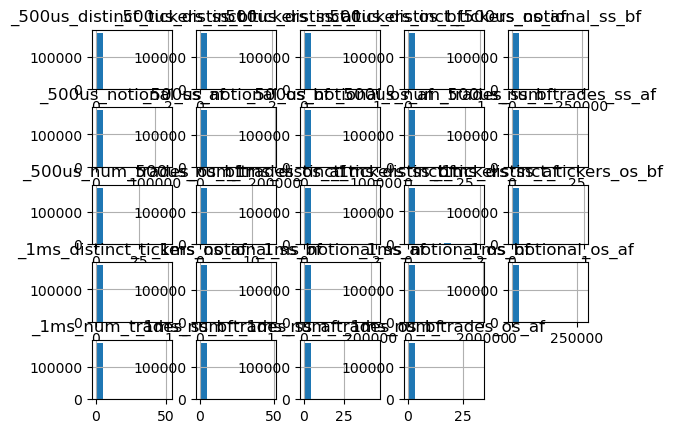

In [ ]:
# etf_execution_features.filter(regex="^_").hist()

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()